<a href="https://colab.research.google.com/github/wiso/TutorialML-AtlasItalia2022/blob/main/notebooks/3.2-VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# preprocessing
train_images = train_images / 255.
test_images = test_images / 255.

# convert the numpy arrays to a tensorflow dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

4431872/4422102 [==============================] - 0s 0us/step


In [4]:


import tensorflow_datasets as tfds
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
train_images[:1].shape

(1, 28, 28)

In [15]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
base_depth = 32


class Autoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1)

        latent_dim_params = tfp.layers.MultivariateNormalTriL.params_size(latent_dim)
        self.encoder = tf.keras.Sequential([
            tfkl.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tfkl.Flatten(),
            tfkl.Dense(latent_dim_params, activation=None),
            tfpl.MultivariateNormalTriL(
                latent_dim,
                activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior)),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[latent_dim]),
            tf.keras.layers.Dense(7 * 7 * 64, activation='relu'),
            tf.keras.layers.Reshape((7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='sigmoid'),

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

latent_dim = 16 
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [17]:
history = autoencoder.fit(train_images, train_images,
                epochs=5,
                batch_size=512,
                validation_data=(test_images, test_images))

Epoch 1/5
118/118 [==============================] - 16s 108ms/step - loss: 1.0194 - val_loss: 0.1960
Epoch 2/5
118/118 [==============================] - 12s 98ms/step - loss: 0.1612 - val_loss: 0.1398
Epoch 3/5
118/118 [==============================] - 12s 98ms/step - loss: 0.1404 - val_loss: 0.1290
Epoch 4/5
118/118 [==============================] - 12s 99ms/step - loss: 0.1342 - val_loss: 0.1162
Epoch 5/5
118/118 [==============================] - 12s 99ms/step - loss: 0.1285 - val_loss: 0.1407


In [18]:
encoded_imgs = autoencoder.encoder(test_images)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

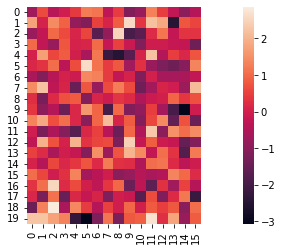

In [19]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(encoded_imgs[:20, :], ax=ax, square=True)
plt.show()

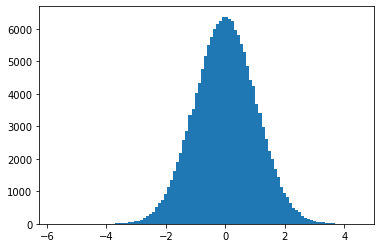

In [20]:
fig, ax = plt.subplots()
ax.hist(encoded_imgs.sample().numpy().flat, bins=100)
plt.show()

In [26]:
decoded_imgs[0, :, :, 0].shape

(28, 28)

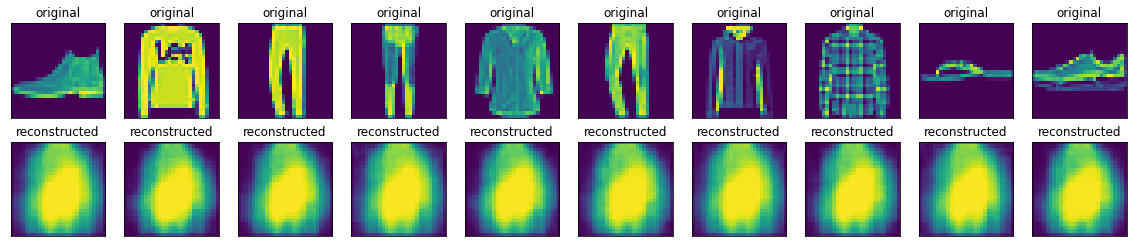

In [27]:
n = 10
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    ax = fig.add_subplot(2, n, i + 1)
    ax.imshow(test_images[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(2, n, i + 1 + n)
    ax.imshow(decoded_imgs[i, :, :, 0])
    ax.set_title("reconstructed")
    
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.show()

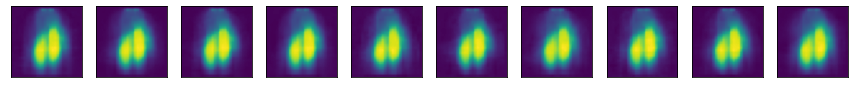

In [13]:
fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for ax in axs.flat:
    noise = np.random.multivariate_normal(np.zeros(latent_dim), np.eye(latent_dim))
    noise = np.expand_dims(noise, axis=0)
    decoded_img = autoencoder.decoder(noise).numpy()[0]
    ax.imshow(decoded_img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')